In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [20]:
def calculate_mse(e):
    """Calculate the mse for vector e."""
    return 1/2*np.mean(e**2)


def calculate_mae(e):
    """Calculate the mae for vector e."""
    return np.mean(np.abs(e))


def compute_loss(y, tx, w, with_mae = False):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y - tx.dot(w)
    if with_mae :
        return calculate_mae(e)
    else :
        return calculate_mse(e)

# 2 Grid Search

Fill in the function `grid_search()` below:

In [21]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    loss = np.zeros((len(w0), len(w1)))
    # compute loss for each combinationof w0 and w1.
    for ind_row, row in enumerate(w0):
        for ind_col, col in enumerate(w1):
            w = np.array([row, col])
            loss[ind_row, ind_col] = compute_loss(y, tx, w)
    return loss

Let us play with the grid search demo now!

Grid Search: loss*=71.12701961084929, w0*=71.42857142857142, w1*=9.183673469387742, execution time=0.036 seconds


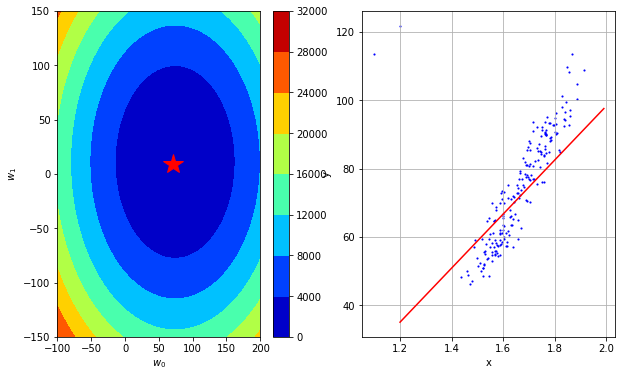

In [22]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [23]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

Please fill in the functions `gradient_descent` below:

In [24]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = calculate_mse(err)
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [25]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2869.8351145358524, w0=51.84746409844845, w1=7.724426406192437
Gradient Descent(1/49): loss=318.28212470159576, w0=67.401703327983, w1=10.04175432805012
Gradient Descent(2/49): loss=88.6423556165126, w0=72.06797509684336, w1=10.736952704607411
Gradient Descent(3/49): loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574597
Gradient Descent(4/49): loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
Gradient Descent(5/49): loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631796
Gradient Descent(6/49): loss=65.93222021235334, w0=74.05160722578589, w1=11.03248153448191
Gradient Descent(7/49): loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536943
Gradient Descent(8/49): loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
Gradient Descent(9/49): loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038408
Gradient Descent(10/49): loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318

In [26]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4 Stochastic gradient descent

In [27]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size):
            # compute a stochastic gradient and loss
            grad, _ = compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate loss
            loss = compute_loss(y, tx, w)
            # store w and loss
            ws.append(w)
            losses.append(loss)
        
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [28]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=1596.7992558837875, w0=39.930682349503755, w1=-32.51270954961437
Gradient Descent(1/49): loss=324.4198981964715, w0=94.12158670820622, w1=21.750500760028032
Gradient Descent(2/49): loss=178.99337991670262, w0=70.8815449169083, w1=25.730916125604196
Gradient Descent(3/49): loss=208.9894398699265, w0=74.40694362326253, w1=27.946500499657777
Gradient Descent(4/49): loss=194.00305237216043, w0=79.36045205927535, w1=26.138951959853127
Gradient Descent(5/49): loss=197.43438430273, w0=84.12576252695199, w1=23.756719262824177
Gradient Descent(6/49): loss=200.7654830468934, w0=83.69308143851313, w1=24.33991556603268
Gradient Descent(7/49): loss=244.83423559267348, w0=76.12356460275157, w1=29.838640954225887
Gradient Descent(8/49): loss=176.30492910105292, w0=82.19169121022261, w1=23.474785730900333
Gradient Descent(9/49): loss=80.58797983162752, w0=68.9263170138751, w1=9.337958816695071
Gradient Descent(10/49): loss=124.08412788904377, w0=64.09653351581095, w1=15.14

In [29]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5 Effect of Outliers and MAE Cost Function, and Subgradient Descent

### Exercise 5

Load and plot data containing outliers

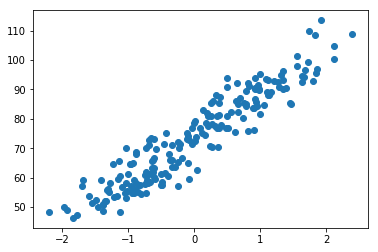

In [30]:
height, weight, gender = load_data(sub_sample=True, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

plt.scatter(x,weight)

In [31]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2829.2722244384163, w0=51.542590721811784, w1=10.132993413506092
Gradient Descent(1/49): loss=267.0500258779424, w0=67.00536793835532, w1=13.17289143755783
Gradient Descent(2/49): loss=36.45002800750035, w0=71.64420110331838, w1=14.084860844773326
Gradient Descent(3/49): loss=15.696028199160633, w0=73.03585105280729, w1=14.358451666937965
Gradient Descent(4/49): loss=13.828168216410077, w0=73.45334603765397, w1=14.440528913587356
Gradient Descent(5/49): loss=13.660060817962522, w0=73.57859453310797, w1=14.46515208758217
Gradient Descent(6/49): loss=13.644931152102242, w0=73.61616908174418, w1=14.472539039780616
Gradient Descent(7/49): loss=13.643569482174817, w0=73.62744144633503, w1=14.474755125440149
Gradient Descent(8/49): loss=13.643446931881353, w0=73.63082315571229, w1=14.47541995113801
Gradient Descent(9/49): loss=13.643435902354941, w0=73.63183766852546, w1=14.475619398847368
Gradient Descent(10/49): loss=13.64343490969756, w0=73.63214202236942, w1=

In [32]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

#### With outliners

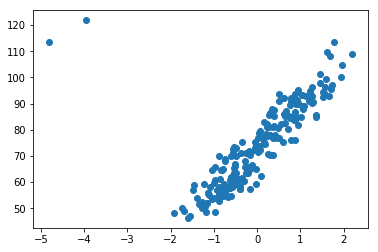

In [33]:
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

plt.scatter(x,weight)

In [34]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2869.8351145358524, w0=51.84746409844845, w1=7.724426406192437
Gradient Descent(1/49): loss=318.28212470159576, w0=67.401703327983, w1=10.04175432805012
Gradient Descent(2/49): loss=88.6423556165126, w0=72.06797509684336, w1=10.736952704607411
Gradient Descent(3/49): loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574597
Gradient Descent(4/49): loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
Gradient Descent(5/49): loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631796
Gradient Descent(6/49): loss=65.93222021235334, w0=74.05160722578589, w1=11.03248153448191
Gradient Descent(7/49): loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536943
Gradient Descent(8/49): loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
Gradient Descent(9/49): loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038408
Gradient Descent(10/49): loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318

In [35]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)

#### Sub gradient

In [97]:
def compute_sub_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    sub_grad = np.sign(err)
    
    return sub_grad.dot(-np.sum(tx,axis = 1)),err

In [98]:
def gradient_sub_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_sub_gradient(y, tx, w)
        loss = calculate_mae(err)
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [99]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.3

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_sub_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=74.06780585492638, w0=60.600000000000065, w1=60.600000000000065
Gradient Descent(1/49): loss=37.98759964875845, w0=29.33034691619054, w1=29.33034691619054
Gradient Descent(2/49): loss=44.73745893873581, w0=89.9303469161906, w1=89.9303469161906
Gradient Descent(3/49): loss=61.33700793972218, w0=33.548097462077095, w1=33.548097462077095
Gradient Descent(4/49): loss=40.519708392849246, w0=94.14809746207716, w1=94.14809746207716
Gradient Descent(5/49): loss=65.27624073094411, w0=36.970616338562365, w1=36.970616338562365
Gradient Descent(6/49): loss=37.504427405582994, w0=81.38553654323445, w1=81.38553654323445
Gradient Descent(7/49): loss=53.612630310262034, w0=27.814075128473334, w1=27.814075128473334
Gradient Descent(8/49): loss=46.253730726453, w0=88.4140751284734, w1=88.4140751284734
Gradient Descent(9/49): loss=59.93495655149446, w0=32.47397357865848, w1=32.47397357865848
Gradient Descent(10/49): loss=41.59383227626787, w0=93.07397357865855, w1=93.07397357

In [100]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

#### Stoch sub gradient

In [101]:
def compute_stoch_sub_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    return compute_sub_gradient(y, tx, w)

def stochastic_sub_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size):
            # compute a stochastic gradient and loss
            grad, _ = compute_stoch_sub_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate loss
            loss = compute_loss(y, tx, w)
            # store w and loss
            ws.append(w)
            losses.append(loss)
        
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [102]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=327.55536750074697, w0=65.63070745796041, w1=32.29670676987448
Gradient Descent(1/49): loss=173.56870864982702, w0=88.71583609373639, w1=11.878202174954502
Gradient Descent(2/49): loss=78.21657594600309, w0=78.8822991129541, w1=12.214872134924786
Gradient Descent(3/49): loss=92.1572835929885, w0=81.08366664019341, w1=12.832338723950256
Gradient Descent(4/49): loss=99.099131940968, w0=81.8533103916555, w1=13.427116173748745
Gradient Descent(5/49): loss=81.33888481452203, w0=79.60339559494282, w1=11.451494978881335
Gradient Descent(6/49): loss=76.36960703313659, w0=70.45243261421187, w1=13.828965407581071
Gradient Descent(7/49): loss=77.18302883180205, w0=70.2933504489376, w1=13.90858306177506
Gradient Descent(8/49): loss=66.40894470943708, w0=74.6698389597713, w1=11.805599319290216
Gradient Descent(9/49): loss=119.07832380310104, w0=66.14247447026071, w1=17.629158270208634
Gradient Descent(10/49): loss=72.15140519159014, w0=70.64981431595298, w1=11.905919559

In [103]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>